In [1]:
!pip install ta
#데이터셋을 만들어 주는 함수
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import LSTM,Dropout,GRU
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

df = pd.read_csv("./[금융]KB금융.csv")
df_columns = ['Date','Open', 'High', 'Low', 'Close', 'Volume']
df.columns = df_columns
df = df.sort_values('Date')
df['Date']= df['Date'].astype('str')
from datetime import datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)

ma = [5,20,60,120]
for days in ma:
    df['ma_'+str(days)] = df['Close'].rolling(window = days).mean()
    df['vma_'+str(days)] = df['Volume'].rolling(window = days).mean()

df.dropna(inplace=True)


import ta

H, L, C, V = df['High'], df['Low'], df['Close'], df['Volume']

# df['bol_high'] = ta.volatility.bollinger_hband(C)
# df['bol_low']  = ta.volatility.bollinger_lband(C)
df['MFI'] = ta.volume.money_flow_index(
    high=H, low=L, close=C, volume=V, fillna=True)

df['ADI'] = ta.volume.acc_dist_index(
    high=H, low=L, close=C, volume=V, fillna=True)

df['OBV'] = ta.volume.on_balance_volume(close=C, volume=V, fillna=True)
df['CMF'] = ta.volume.chaikin_money_flow(
    high=H, low=L, close=C, volume=V, fillna=True)

df['FI'] = ta.volume.force_index(close=C, volume=V, fillna=True)
df['EOM, EMV'] = ta.volume.ease_of_movement(
    high=H, low=L, volume=V, fillna=True)

df['VPT'] = ta.volume.volume_price_trend(close=C, volume=V, fillna=True)
df['NVI'] = ta.volume.negative_volume_index(close=C, volume=V, fillna=True)
df['VMAP'] = ta.volume.volume_weighted_average_price(
    high=H, low=L, close=C, volume=V, fillna=True)

# Volatility
df['ATR'] = ta.volatility.average_true_range(
    high=H, low=L, close=C, fillna=True)
df['BHB'] = ta.volatility.bollinger_hband(close=C, fillna=True)
df['BLB'] = ta.volatility.bollinger_lband(close=C, fillna=True)
df['KCH'] = ta.volatility.keltner_channel_hband(
    high=H, low=L, close=C, fillna=True)
df['KCL'] = ta.volatility.keltner_channel_lband(
    high=H, low=L, close=C, fillna=True)
df['KCM'] = ta.volatility.keltner_channel_mband(
    high=H, low=L, close=C, fillna=True)
df['DCH'] = ta.volatility.donchian_channel_hband(
    high=H, low=L, close=C, fillna=True)
df['DCL'] = ta.volatility.donchian_channel_lband(
    high=H, low=L, close=C, fillna=True)
df['DCM'] = ta.volatility.donchian_channel_mband(
    high=H, low=L, close=C, fillna=True)
df['UI'] = ta.volatility.ulcer_index(close=C, fillna=True)
# Trend
df['SMA'] = ta.trend.sma_indicator(close=C, fillna=True)
df['EMA'] = ta.trend.ema_indicator(close=C, fillna=True)
df['WMA'] = ta.trend.wma_indicator(close=C, fillna=True)
df['MACD'] = ta.trend.macd(close=C, fillna=True)
df['ADX'] = ta.trend.adx(high=H, low=L, close=C, fillna=True)
df['-VI'] = ta.trend.vortex_indicator_neg(
    high=H, low=L, close=C, fillna=True)
df['+VI'] = ta.trend.vortex_indicator_pos(
    high=H, low=L, close=C, fillna=True)
df['TRIX'] = ta.trend.trix(close=C, fillna=True)
df['MI'] = ta.trend.mass_index(high=H, low=L, fillna=True)
df['CCI'] = ta.trend.cci(high=H, low=L, close=C, fillna=True)
df['DPO'] = ta.trend.dpo(close=C, fillna=True)
df['KST'] = ta.trend.kst(close=C, fillna=True)
df['Ichimoku'] = ta.trend.ichimoku_a(high=H, low=L, fillna=True)
df['Parabolic SAR'] = ta.trend.psar_down(
    high=H, low=L, close=C, fillna=True)
df['STC'] = ta.trend.stc(close=C, fillna=True)
# Momentum
df['RSI'] = ta.momentum.rsi(close=C, fillna=True)
df['SRSI'] = ta.momentum.stochrsi(close=C, fillna=True)
df['TSI'] = ta.momentum.tsi(close=C, fillna=True)
df['UO'] = ta.momentum.ultimate_oscillator(
    high=H, low=L, close=C, fillna=True)
df['SR'] = ta.momentum.stoch(close=C, high=H, low=L, fillna=True)
df['WR'] = ta.momentum.williams_r(high=H, low=L, close=C, fillna=True)
df['AO'] = ta.momentum.awesome_oscillator(high=H, low=L, fillna=True)
df['KAMA'] = ta.momentum.kama(close=C, fillna=True)
df['ROC'] = ta.momentum.roc(close=C, fillna=True)
df['PPO'] = ta.momentum.ppo(close=C, fillna=True)
df['PVO'] = ta.momentum.pvo(volume=V, fillna=True)


from sklearn.preprocessing import MinMaxScaler

# 피처값 스케일링
scaler = MinMaxScaler()

scaled_df = scaler.fit_transform(df.drop(['Close'], axis=1))
scaled_df = pd.DataFrame(scaled_df, columns = df.drop(['Close'], axis=1).columns)

scaler1 = MinMaxScaler()

temp = scaler1.fit_transform(df['Close'].values.reshape(-1,1))

scaled_df.insert(3, 'Close',temp)
scaled_df

df = scaled_df



import numpy as np

def make_dataset(feature, label, window_size = 20):
  
  feature_list = []
  label_list = []
  
  for i in range(len(feature) - window_size) :
    feature_list.append(feature.iloc[i:i+window_size])
    label_list.append(label.iloc[i+window_size])
  
  return np.array(feature_list), np.array(label_list)

WINDOW_SIZE=20

result = []
predict = []


####최근 20개의 데이터만
pred_feature = df[-WINDOW_SIZE :]
pred_feature = pred_feature.to_numpy()

pred_feature = pred_feature.reshape((1,20,-1))
# pred_feature.shape

import random as rn
import tensorflow as tf


for i in range(1, len(df)//1000+2):

        # 데이터 불러오기
        df_copy = df
     
        # 원하는 크기로 데이터 자르기
        df_copy = df_copy[-i*1000:]
        # 피처값, 타켓 스케일링
        
        TEST_SIZE = int(len(df_copy) * 0.7)
        
        train = df_copy[:TEST_SIZE]
        test = df_copy[TEST_SIZE:]

##200일의 데이터를 얼마나 잘 예측하느냐
        
        # feature_cols = df.drop('Close', axis =1).columns
        feature_cols = df.columns
        label_cols = ['Close']

        train_feature = train[feature_cols]
        train_label = train[label_cols]

        train_feature, train_label = make_dataset(train_feature, train_label,20)

        from sklearn.model_selection import train_test_split
        x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2, shuffle = False)
        
        
        test_feature = test[feature_cols]
        test_label = test[label_cols]
        test_feature , test_label = make_dataset(test_feature, test_label,20)
        
        
        from keras.layers.normalization import batch_normalization

        model = Sequential()
        model.add(GRU(16, 
                      input_shape=(train_feature.shape[1], train_feature.shape[2]), 
                      return_sequences = False,
                      activation='relu'))
        model.add(Dense(1))
      
        
        model.compile(loss='mean_squared_error', optimizer='adam')

        early_stop = EarlyStopping(monitor='val_loss', patience=10)

        import os
        from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

        model_path = 'model'
        filename = os.path.join(model_path, 'tmp_checkpoint.h5')
        checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

        history = model.fit(x_train, y_train, 
                                            epochs=100, 
                                            batch_size=16,
                                            validation_data=(x_valid, y_valid), 
                                            callbacks=[early_stop, checkpoint])


        pred = model.predict(test_feature)
        # rescaleing 작업
        rescaled_y_true = scaler1.inverse_transform(np.array(test_label).reshape(-1, 1))
        rescaled_pred = scaler1.inverse_transform(np.array(pred).reshape(-1,1))
        
        
        # 평가지표(RMSE) 계산
        RMSE = np.sqrt(mean_squared_error(rescaled_y_true, rescaled_pred))
        result.append(RMSE)
        print(f"{i * 1000}길이의 데이터 적용 완료\n 길이: {i * 1000}, RMSE:{RMSE}")
        print(result)
        

        new_pred = model.predict(pred_feature)
        rescaled_newpred = scaler1.inverse_transform(np.array(new_pred).reshape(-1,1))
        predict.append(rescaled_newpred)



C:\Users\gram\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\gram\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


Epoch 1/100
29/34 [========================>.....] - ETA: 0s - loss: 0.0135
Epoch 1: val_loss improved from inf to 0.00490, saving model to model\tmp_checkpoint.h5
34/34 [==============================] - 2s 19ms/step - loss: 0.0121 - val_loss: 0.0049
Epoch 2/100
32/34 [===========================>..] - ETA: 0s - loss: 0.0032
Epoch 2: val_loss did not improve from 0.00490
34/34 [==============================] - 0s 7ms/step - loss: 0.0031 - val_loss: 0.0089
Epoch 3/100
30/34 [=========================>....] - ETA: 0s - loss: 0.0018
Epoch 3: val_loss did not improve from 0.00490
34/34 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0059
Epoch 4/100
27/34 [======================>.......] - ETA: 0s - loss: 0.0013
Epoch 4: val_loss did not improve from 0.00490
34/34 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0060
Epoch 5/100
30/34 [=========================>....] - ETA: 0s - loss: 9.9228e-04
Epoch 5: val_loss did not improve from

28/34 [=======================>......] - ETA: 0s - loss: 4.4202e-04
Epoch 36: val_loss improved from 0.00189 to 0.00163, saving model to model\tmp_checkpoint.h5
34/34 [==============================] - 0s 8ms/step - loss: 4.5042e-04 - val_loss: 0.0016
Epoch 37/100
28/34 [=======================>......] - ETA: 0s - loss: 4.7264e-04
Epoch 37: val_loss did not improve from 0.00163
34/34 [==============================] - 0s 8ms/step - loss: 4.6620e-04 - val_loss: 0.0024
Epoch 38/100
26/34 [=====================>........] - ETA: 0s - loss: 5.0723e-04
Epoch 38: val_loss did not improve from 0.00163
34/34 [==============================] - 0s 8ms/step - loss: 4.7983e-04 - val_loss: 0.0020
Epoch 39/100
27/34 [======================>.......] - ETA: 0s - loss: 4.5524e-04
Epoch 39: val_loss did not improve from 0.00163
34/34 [==============================] - 0s 8ms/step - loss: 4.4876e-04 - val_loss: 0.0018
Epoch 40/100
29/34 [========================>.....] - ETA: 0s - loss: 4.7834e-04
Epoch 4

69/69 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 5/100
68/69 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 5: val_loss did not improve from 0.00151
69/69 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 6/100
67/69 [============================>.] - ETA: 0s - loss: 8.7254e-04
Epoch 6: val_loss improved from 0.00151 to 0.00136, saving model to model\tmp_checkpoint.h5
69/69 [==============================] - 1s 8ms/step - loss: 8.6985e-04 - val_loss: 0.0014
Epoch 7/100
69/69 [==============================] - ETA: 0s - loss: 8.6964e-04
Epoch 7: val_loss improved from 0.00136 to 0.00101, saving model to model\tmp_checkpoint.h5
69/69 [==============================] - 1s 9ms/step - loss: 8.6964e-04 - val_loss: 0.0010
Epoch 8/100
62/69 [=========================>....] - ETA: 0s - loss: 7.1514e-04
Epoch 8: val_loss improved from 0.00101 to 0.00079, saving model to model\tmp_checkpoint.h5
69/69

63/69 [==========================>...] - ETA: 0s - loss: 4.1351e-04
Epoch 39: val_loss improved from 0.00044 to 0.00044, saving model to model\tmp_checkpoint.h5
69/69 [==============================] - 1s 11ms/step - loss: 4.1399e-04 - val_loss: 4.3851e-04
Epoch 40/100
67/69 [============================>.] - ETA: 0s - loss: 4.2664e-04
Epoch 40: val_loss improved from 0.00044 to 0.00043, saving model to model\tmp_checkpoint.h5
69/69 [==============================] - 1s 12ms/step - loss: 4.2544e-04 - val_loss: 4.2898e-04
Epoch 41/100
69/69 [==============================] - ETA: 0s - loss: 3.9856e-04
Epoch 41: val_loss did not improve from 0.00043
69/69 [==============================] - 1s 10ms/step - loss: 3.9856e-04 - val_loss: 4.3599e-04
Epoch 42/100
67/69 [============================>.] - ETA: 0s - loss: 5.0136e-04
Epoch 42: val_loss did not improve from 0.00043
69/69 [==============================] - 1s 10ms/step - loss: 4.9538e-04 - val_loss: 4.8302e-04
Epoch 43/100
66/69 [===

Epoch 2/100
 97/104 [==========================>...] - ETA: 0s - loss: 0.0018
Epoch 2: val_loss improved from 0.00533 to 0.00302, saving model to model\tmp_checkpoint.h5
104/104 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 3/100
100/104 [===========================>..] - ETA: 0s - loss: 0.0013
Epoch 3: val_loss improved from 0.00302 to 0.00297, saving model to model\tmp_checkpoint.h5
104/104 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 4/100
 96/104 [==========================>...] - ETA: 0s - loss: 0.0010
Epoch 4: val_loss did not improve from 0.00297
104/104 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 0.0034
Epoch 5/100
 99/104 [===========================>..] - ETA: 0s - loss: 8.4938e-04
Epoch 5: val_loss improved from 0.00297 to 0.00133, saving model to model\tmp_checkpoint.h5
104/104 [==============================] - 1s 7ms/step - loss: 8.4573e-04 - val_loss: 0.0013
E

Epoch 10/100
109/113 [===========================>..] - ETA: 0s - loss: 5.5231e-04
Epoch 10: val_loss did not improve from 0.00059
113/113 [==============================] - 2s 14ms/step - loss: 5.5129e-04 - val_loss: 6.0105e-04
Epoch 11/100
110/113 [============================>.] - ETA: 0s - loss: 5.5650e-04
Epoch 11: val_loss improved from 0.00059 to 0.00057, saving model to model\tmp_checkpoint.h5
113/113 [==============================] - 2s 13ms/step - loss: 5.5731e-04 - val_loss: 5.7444e-04
Epoch 12/100
112/113 [============================>.] - ETA: 0s - loss: 5.5525e-04
Epoch 12: val_loss did not improve from 0.00057
113/113 [==============================] - 1s 13ms/step - loss: 5.5332e-04 - val_loss: 7.6966e-04
Epoch 13/100
112/113 [============================>.] - ETA: 0s - loss: 5.1098e-04
Epoch 13: val_loss improved from 0.00057 to 0.00055, saving model to model\tmp_checkpoint.h5
113/113 [==============================] - 1s 13ms/step - loss: 5.1660e-04 - val_loss: 5.520

113/113 [==============================] - 1s 13ms/step - loss: 5.0104e-04 - val_loss: 6.2862e-04
Epoch 45/100
108/113 [===========================>..] - ETA: 0s - loss: 4.2519e-04
Epoch 45: val_loss did not improve from 0.00045
113/113 [==============================] - 2s 16ms/step - loss: 4.2339e-04 - val_loss: 5.0005e-04
Epoch 46/100
110/113 [============================>.] - ETA: 0s - loss: 4.3597e-04
Epoch 46: val_loss did not improve from 0.00045
113/113 [==============================] - 1s 11ms/step - loss: 4.3507e-04 - val_loss: 4.6931e-04
Epoch 47/100
112/113 [============================>.] - ETA: 0s - loss: 4.4911e-04
Epoch 47: val_loss did not improve from 0.00045
113/113 [==============================] - 1s 12ms/step - loss: 4.4936e-04 - val_loss: 7.6490e-04
Epoch 48/100
110/113 [============================>.] - ETA: 0s - loss: 4.5024e-04
Epoch 48: val_loss did not improve from 0.00045
113/113 [==============================] - 1s 12ms/step - loss: 4.4956e-04 - val_los

In [2]:
print(predict)

[array([[60465.605]], dtype=float32), array([[62018.934]], dtype=float32), array([[60668.703]], dtype=float32), array([[59230.133]], dtype=float32)]


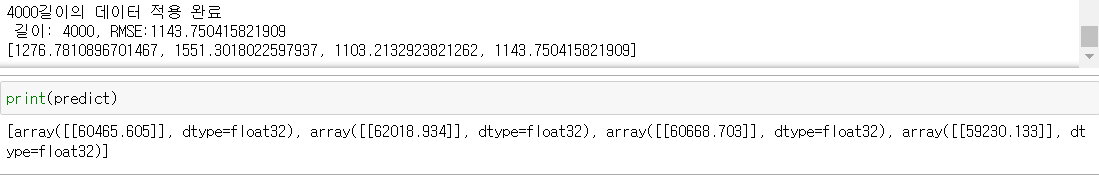